In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

In [2]:
# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

In [3]:
# Modules required for accessing the file system.
import os

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

In [5]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.metrics import roc_curve, precision_recall_curve

In [6]:
import collections

In [7]:
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [8]:
TRAIN_CSV_DIR = "D:\\retinal_data\\Training_Set\\Training_Set\\RFMiD_Training_Labels.csv"
TEST_CSV_DIR = "D:\\retinal_data\\Test_Set\\Test_Set\\RFMiD_Testing_Labels.csv"
VAL_CSV_DIR = "D:\\retinal_data\\Evaluation_Set\\Evaluation_Set\\RFMiD_Validation_Labels.csv"

In [9]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [10]:
import tensorflow as tf
tf.test.is_gpu_available()

False

In [11]:
train_labels = pd.read_csv(TRAIN_CSV_DIR)
test_labels = pd.read_csv(TEST_CSV_DIR)
val_labels = pd.read_csv(VAL_CSV_DIR)

In [12]:
train_labels.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


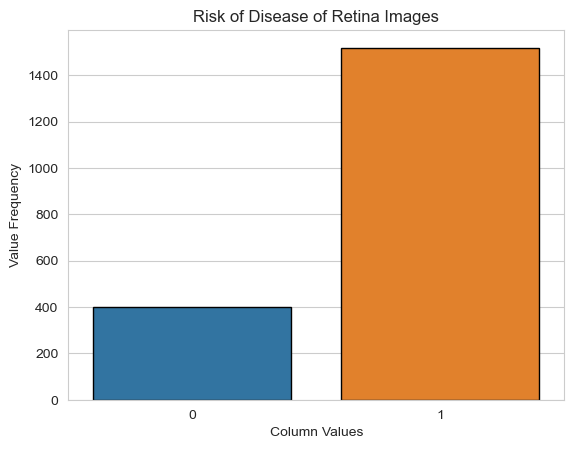

In [13]:
disease_risk_col = dict(train_labels["Disease_Risk"].value_counts())
col_labels = list(disease_risk_col.keys())
label_freq = list(disease_risk_col.values())
sns.barplot(x = col_labels,
            y = label_freq,
            edgecolor = "black")
plt.title("Risk of Disease of Retina Images")
plt.xlabel("Column Values")
plt.ylabel("Value Frequency")
plt.show()

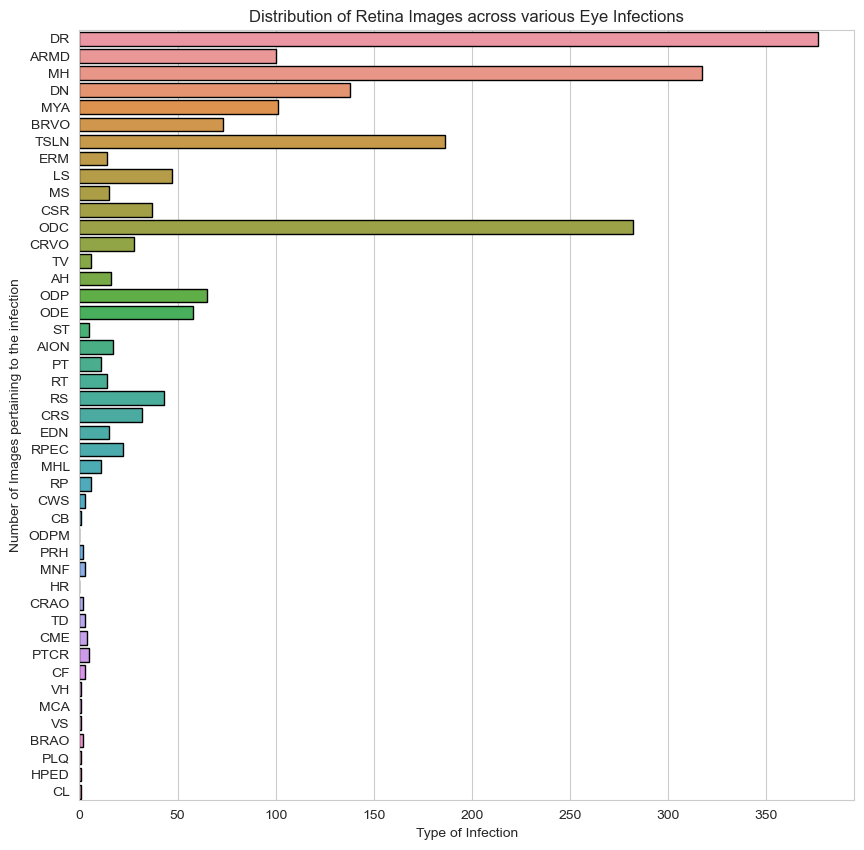

In [14]:
infected_retinas = dict(train_labels.drop(["ID", "Disease_Risk"], axis=1).sum())
retina_infections = list(infected_retinas.keys())
infection_freq = list(infected_retinas.values())
plt.figure(figsize = (10,10))
sns.barplot(y = retina_infections,
            x = infection_freq,
            edgecolor = "black",
            orient = "h")
plt.title("Distribution of Retina Images across various Eye Infections")
plt.xlabel("Type of Infection")
plt.ylabel("Number of Images pertaining to the infection")
plt.show()

In [15]:
train_labels.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
       'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
       'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
       'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
       'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
      dtype='object')

In [16]:
columns_to_keep = [
    'ID',
    'Disease_Risk',
    'DR',
    'ARMD',
    'MH',
    'MYA',
    'BRVO',
    'ST',
    'MCA',
    'BRAO',
    'PLQ'
]

In [17]:
train_labels = train_labels[columns_to_keep]
test_labels = test_labels[columns_to_keep]
val_labels = val_labels[columns_to_keep]

In [18]:
train_labels.count()

ID              1920
Disease_Risk    1920
DR              1920
ARMD            1920
MH              1920
MYA             1920
BRVO            1920
ST              1920
MCA             1920
BRAO            1920
PLQ             1920
dtype: int64

In [19]:
test_labels.count()

ID              640
Disease_Risk    640
DR              640
ARMD            640
MH              640
MYA             640
BRVO            640
ST              640
MCA             640
BRAO            640
PLQ             640
dtype: int64

In [20]:
val_labels.count()

ID              640
Disease_Risk    640
DR              640
ARMD            640
MH              640
MYA             640
BRVO            640
ST              640
MCA             640
BRAO            640
PLQ             640
dtype: int64

In [21]:
TRAIN_IMG_DIR="D:\\retinal_data\\Training_Set\\Training_Set\\Training"
TEST_IMG_DIR = "D:\\retinal_data\\Test_Set\\Test_Set\\Test"
VAL_IMG_DIR = "D:\\retinal_data\\Evaluation_Set\\Evaluation_Set\\Validation"

In [22]:
def id_to_path(id : int, IMG_DIR : str):
    return os.path.join(IMG_DIR, str(id) + ".png")

In [23]:
train_labels["IMG_DIR"] = TRAIN_IMG_DIR
train_labels["IMG_DIR"] = train_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                             axis=1)
test_labels["IMG_DIR"] = TEST_IMG_DIR
test_labels["IMG_DIR"] = test_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                           axis=1)
val_labels["IMG_DIR"] = VAL_IMG_DIR
val_labels["IMG_DIR"] = val_labels.apply(lambda x: id_to_path(x.ID, x.IMG_DIR), 
                                         axis=1)

In [24]:
class ImagePreprocessor:
    # Initialization of the Type of model and Input Size.
    def __init__(self, cnn_variant, input_size):
        self.cnn_variant = cnn_variant
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.input_size = input_size
        
    # Creation of image generators based on the respective model requirements.
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )
    
    # Basic image preprocessing for the intiating the training process.
    def preprocess(self):
        train_images = self.train_gen.flow_from_dataframe(
              train_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        val_images = self.val_gen.flow_from_dataframe(
              test_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              target_size=self.input_size,
              color_mode='rgb',
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        test_images = self.test_gen.flow_from_dataframe(
              val_labels,
              x_col="IMG_DIR", 
              y_col="Disease_Risk",
              color_mode='rgb',
              target_size=self.input_size,
              batch_size=32,
              class_mode="binary",
              shuffle=False
        )

        return train_images, val_images, test_images

In [25]:
train_labels.columns

Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'MYA', 'BRVO', 'ST', 'MCA',
       'BRAO', 'PLQ', 'IMG_DIR'],
      dtype='object')

In [26]:
print(train_labels.columns)
print(test_labels.columns)
print(val_labels.columns)


Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'MYA', 'BRVO', 'ST', 'MCA',
       'BRAO', 'PLQ', 'IMG_DIR'],
      dtype='object')
Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'MYA', 'BRVO', 'ST', 'MCA',
       'BRAO', 'PLQ', 'IMG_DIR'],
      dtype='object')
Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'MYA', 'BRVO', 'ST', 'MCA',
       'BRAO', 'PLQ', 'IMG_DIR'],
      dtype='object')


In [27]:
train_labels["Disease_Risk"] = train_labels["Disease_Risk"].astype(str)
test_labels["Disease_Risk"] = test_labels["Disease_Risk"].astype(str)
val_labels["Disease_Risk"] = val_labels["Disease_Risk"].astype(str)

In [28]:
# A class for the domain adaptation of any Tensorflow-based CNN.
class TransferLearning:

    # Initialization of the model, its preprocessed training data, and its preprocessed validation data.
    def __init__(self, train, val, model) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.input_size = (200,200,3)
    
    # Marking few layers as non-trainable.
    def mark_layers_non_trainable(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False
        
        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True
    
    # Addition of the final layer based on the dataset and its classes.
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(1, activation = 'sigmoid')(self.x)
    
    # Compilation fo the model with appropriate classification metrics.
    def compile_model(self):
        self.model = Model(inputs = self.model.input, 
                           outputs = self.predictions)

        self.model.compile(optimizer='adam', 
                           loss="binary_crossentropy", 
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalseNegatives(name="false_negatives"),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])
    
    # Train model with a callback for Early Stopping.
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32, 
                                      epochs=50, 
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=5,
                                            restore_best_weights=True
                                        )
                                     ])

In [29]:
def experiment_model(preprocessing_function, model, input_size):

    # Image Preprocessing based on CNN requirements.
    preprocessor = ImagePreprocessor(preprocessing_function, 
                                     input_size)
    preprocessor.create_generators()
    train, val, test = preprocessor.preprocess()

    # Domain Adaptation of the CNN architecture.
    modelbuilder = TransferLearning(train, val, 
                                    model)
    modelbuilder.mark_layers_non_trainable()
    modelbuilder.add_final_layer()
    modelbuilder.compile_model()
    modelbuilder.train_model()

    # Returing results for Model Evaluation and Post-Processing.
    return modelbuilder.model, modelbuilder.history, test

In [30]:
# A class for evaluating the model based on the training history and other classification metrics.
class ModelEvaluator:

    # Initialization of the Evaluator with the training history, Model, its preprocessed test data,
    # decision threshold, and class labels.
    def __init__(self, history, classes : list, model, test, threshold : float):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None
        self.t = threshold
    
    # A comparision of the train and validation data on a specific metric
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):
        
        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])
        ax.title.set_text(train_metric + " v/s " + val_metric)
        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])
    
    # Plotting all the parameters in the training history.
    def training_history(self):
        rows = 4
        columns = 2
        c = 0
        metrics = ["loss", "accuracy", "auc", "false_negatives", 
                   "false_positives", "precision", "recall"]
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        for metric in metrics:
            self.__plot_metric(axs[c//columns, c%columns], 
                               metric.replace("_", " ").title(), 
                               metric, "val_"+metric)
            c += 1
        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, 
                            hspace=0.5)
        plt.show()
    
    # Application of the decision threshold to the model logits.
    def __clip_sigmoid_output(self, p : float):
        if p >= self.t:
            return 1
        else:
            return 0
    
    # Model Prediction and Thresholding of results.
    def predict(self):
        self.predictions = self.model.predict(self.test).flatten()
        self.predictions = list(map(self.__clip_sigmoid_output, 
                                    self.predictions))
    
    # Model Evaluation using the thresholded predictions.
    def class_report(self):
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, 
                                             self.predictions, 
                                             num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(self.test.labels, 
                                    self.predictions, 
                                    target_names=self.classes))

In [31]:
class ThresholdTuner:

    # Initialization of the model and its preprocessed test data.
    def __init__(self, model, test):
        self.model = model
        self.test = test
        self.predictions_raw = None
        self.f1_scores = []
    
    # Predictions of the model on the test data.
    def __predict_test(self):
        self.predictions_raw = self.model.predict(self.test).flatten()
    
    # Application of the decision threshold to the model logits.
    def __clip_logits(self, t : float, p : float):
        if p >= t:
            return 1
        else:
            return 0
    
    # Plotting the distribution of the sigmoid logits.
    def __plot_raw_logits(self, ax):
        ax.hist(self.predictions_raw, edgecolor="black")
        ax.title.set_text("Distribution of logits at final layer")
        ax.set_xlabel("Logits")
        ax.set_ylabel("Frequency")
    
    # Threshold tuning using Receiver-Operator Curve.
    def __tune_threshold_roc_curve(self, ax):
        fpr, tpr, thresholds = roc_curve(self.test.labels, self.predictions_raw)
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-mean=%.3f using ROC curve' % (thresholds[ix], gmeans[ix]))
        ax.plot([0,1], [0,1], linestyle='--', label='No Skill') 
        ax.plot(fpr, tpr, marker='.', label='Logistic') 
        ax.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best') 
        # axis labels
        ax.title.set_text("ROC Curve")
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.legend()
    
    # Threshold tuning using Precision-Recall Curve.
    def __tune_threshold_pr_curve(self, ax):
        precision, recall, thresholds = precision_recall_curve(self.test.labels, self.predictions_raw)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.argmax(fscore)
        print('Best Threshold=%f, F-score=%.3f using PR Curve' % (thresholds[ix], fscore[ix]))
        no_skill = np.count_nonzero(self.test.labels == 1) / len(self.test.labels)
        ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill') 
        ax.plot(recall, precision, marker='.', label='Logistic') 
        ax.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best') 
        ax.title.set_text("PR Curve")
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.legend()
    
    # Threshold tuning using Grid Search for maximum F-score.
    def __tune_threshold_grid_search(self, ax):
        self.ts = np.arange(0, 1.0, 0.001)
        for threshold in self.ts:
            pred = list(map(lambda p: self.__clip_logits(threshold, p), 
                            self.predictions_raw))
            self.f1_scores.append(f1_score(self.test.labels, pred))
        
        ax.plot(self.ts, self.f1_scores)
        max_f1_score = max(self.f1_scores)
        max_threshold = self.ts[np.argmax(self.f1_scores)]
        print('Best Threshold=%f, F-score=%.3f using Grid Search' % (max_threshold, max_f1_score))
        ax.plot(max_threshold, max_f1_score, 'ro')
        ax.plot(0.50, self.f1_scores[500], 'go')
        ax.title.set_text("Tuning of the Threshold")
        ax.set_xlabel("Threshold Value")
        ax.set_xlabel("F1 score")
    
    # Consolidation of the results from the Threshold Tuner.
    def find_optimal_thresholds(self):
        self.__predict_test()
        rows = 2
        columns = 2
        fig, axs = plt.subplots(rows, columns,figsize=(15,15))
        self.__plot_raw_logits(axs[0,0])
        self.__tune_threshold_roc_curve(axs[0,1])
        self.__tune_threshold_pr_curve(axs[1,0])
        self.__tune_threshold_grid_search(axs[1,1])
        fig.suptitle("Threshold Moving for Imbalanced Classification")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

**VGG**

In [33]:
vgg, history, vgg_test = experiment_model(cnns.vgg16, 
                                        cnns.vgg16.VGG16(include_top=False, 
                                        input_shape=(200,200,3)),
                                         (200, 200))

Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/50
60/60 [==============================] - 335s 6s/step - loss: 22.7942 - accuracy: 0.7807 - auc: 0.6679 - false_negatives: 205.0000 - false_positives: 216.0000 - precision: 0.8588 - recall: 0.8650 - val_loss: 7.7337 - val_accuracy: 0.7188 - val_auc: 0.7264 - val_false_negatives: 143.0000 - val_false_positives: 37.0000 - val_precision: 0.9075 - val_recall: 0.7174
Epoch 2/50
60/60 [==============================] - 307s 5s/step - loss: 2.2407 - accuracy: 0.8469 - auc: 0.8138 - false_negatives: 158.0000 - false_positives: 136.0000 - precision: 0.9092 - recall: 0.8960 - val_loss: 1.0531 - val_accuracy: 0.8781 - val_auc: 0.8238 - val_false_negatives: 22.0000 - val_false_positives: 56.0000 - val_precision: 0.8963 - val_recall: 0.9565
Epoch 3/50
60/60 [==============================] - 315s 5s/step - loss

In [34]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], vgg, vgg_test, 0.5)

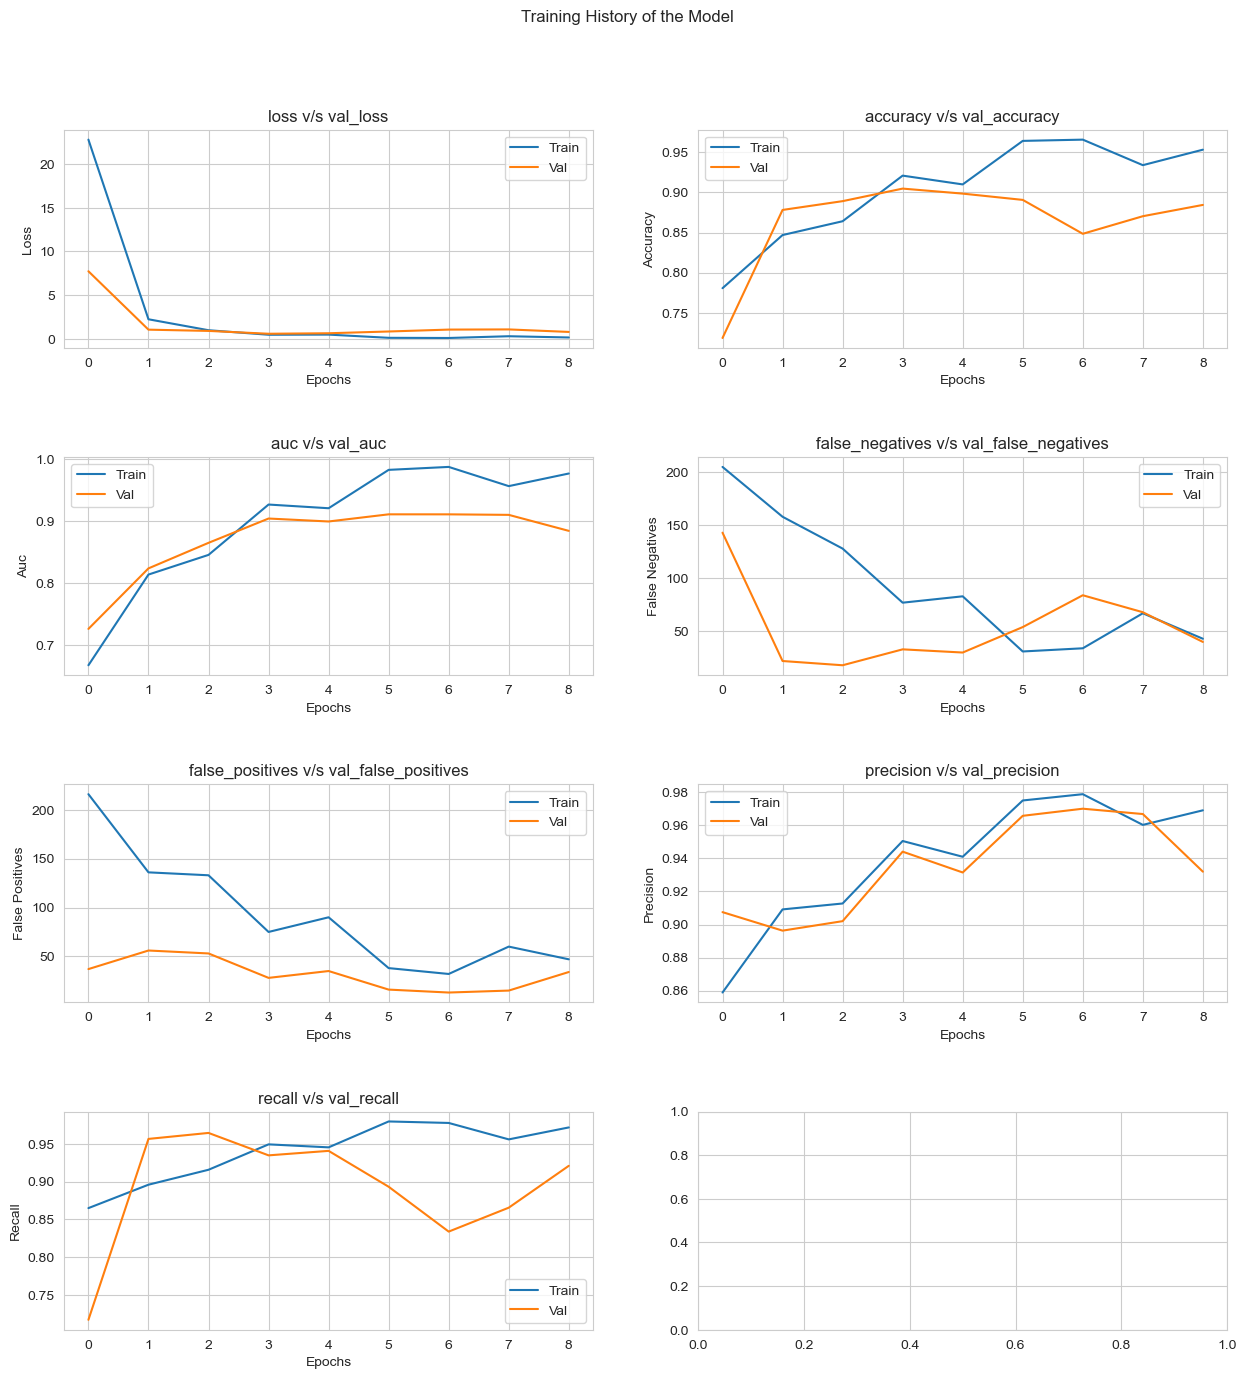

20/20 [==============================] - 86s 4s/step


In [36]:
me.training_history()
prediction = me.predict()

              precision    recall  f1-score   support

Not Infected       0.65      0.57      0.61       134
    Infected       0.89      0.92      0.90       506

    accuracy                           0.85       640
   macro avg       0.77      0.75      0.76       640
weighted avg       0.84      0.85      0.84       640



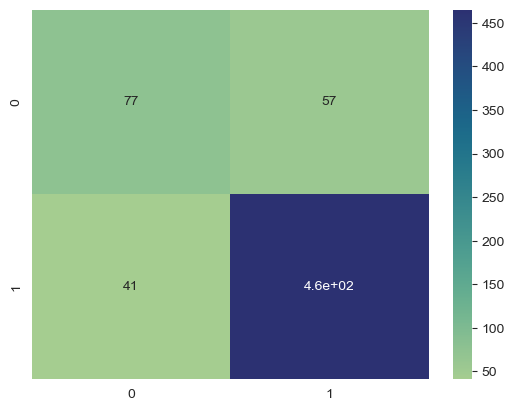

In [37]:
me.class_report()

In [ ]:
tuner = ThresholdTuner(vgg, vgg_test)

In [ ]:
tuner.find_optimal_thresholds()

**NASANet**

In [32]:
nasnet, history, nasnet_test = experiment_model(cnns.nasnet, 
                                                cnns.nasnet.NASNetMobile(include_top=False, 
                                                    input_shape=(224,224,3),
                                                    weights='imagenet'),
                                                (224,224))

19993432/19993432 [==============================] - 27s 1us/step
Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/50
60/60 [==============================] - 768s 11s/step - loss: 3.6508 - accuracy: 0.7536 - auc: 0.6474 - false_negatives: 140.0000 - false_positives: 333.0000 - precision: 0.8055 - recall: 0.9078 - val_loss: 2.5350 - val_accuracy: 0.7906 - val_auc: 0.5000 - val_false_negatives: 0.0000e+00 - val_false_positives: 134.0000 - val_precision: 0.7906 - val_recall: 1.0000
Epoch 2/50
60/60 [==============================] - 622s 10s/step - loss: 0.3528 - accuracy: 0.8271 - auc: 0.8674 - false_negatives: 138.0000 - false_positives: 194.0000 - precision: 0.8768 - recall: 0.9092 - val_loss: 0.3447 - val_accuracy: 0.8219 - val_auc: 0.9297 - val_false_negatives: 4.0000 - val_false_positives: 110.0000 - val_precision: 0.8203 - val_recall: 0.9921
E

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], nasnet, nasnet_test, 0.5)

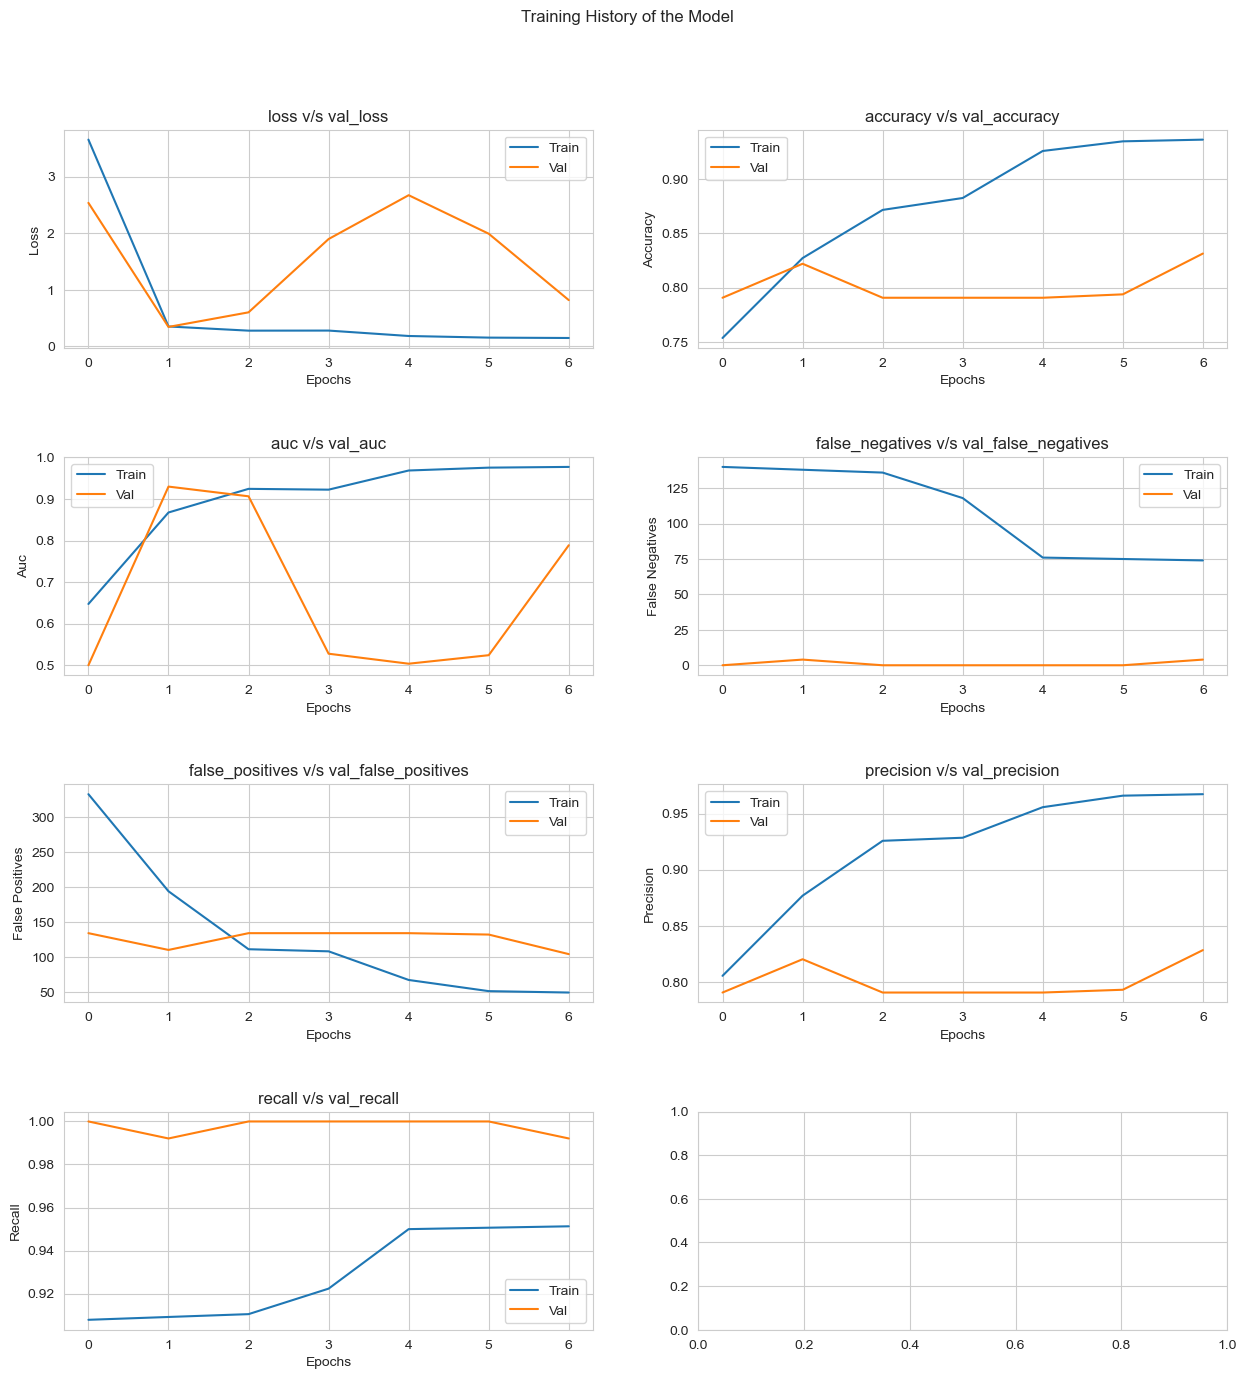

20/20 [==============================] - 71s 3s/step


In [34]:
me.training_history()
me.predict()

              precision    recall  f1-score   support

Not Infected       0.75      0.11      0.19       134
    Infected       0.81      0.99      0.89       506

    accuracy                           0.81       640
   macro avg       0.78      0.55      0.54       640
weighted avg       0.80      0.81      0.74       640



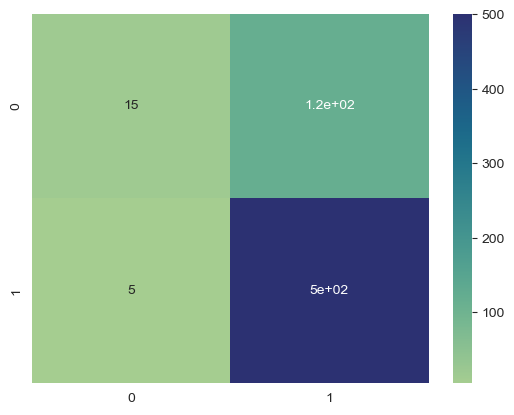

In [35]:
me.class_report()

In [36]:
tuner = ThresholdTuner(nasnet, nasnet_test)

20/20 [==============================] - 62s 3s/step
Best Threshold=0.962472, G-mean=0.836 using ROC curve
Best Threshold=0.811522, F-score=0.917 using PR Curve
Best Threshold=0.804000, F-score=0.917 using Grid Search


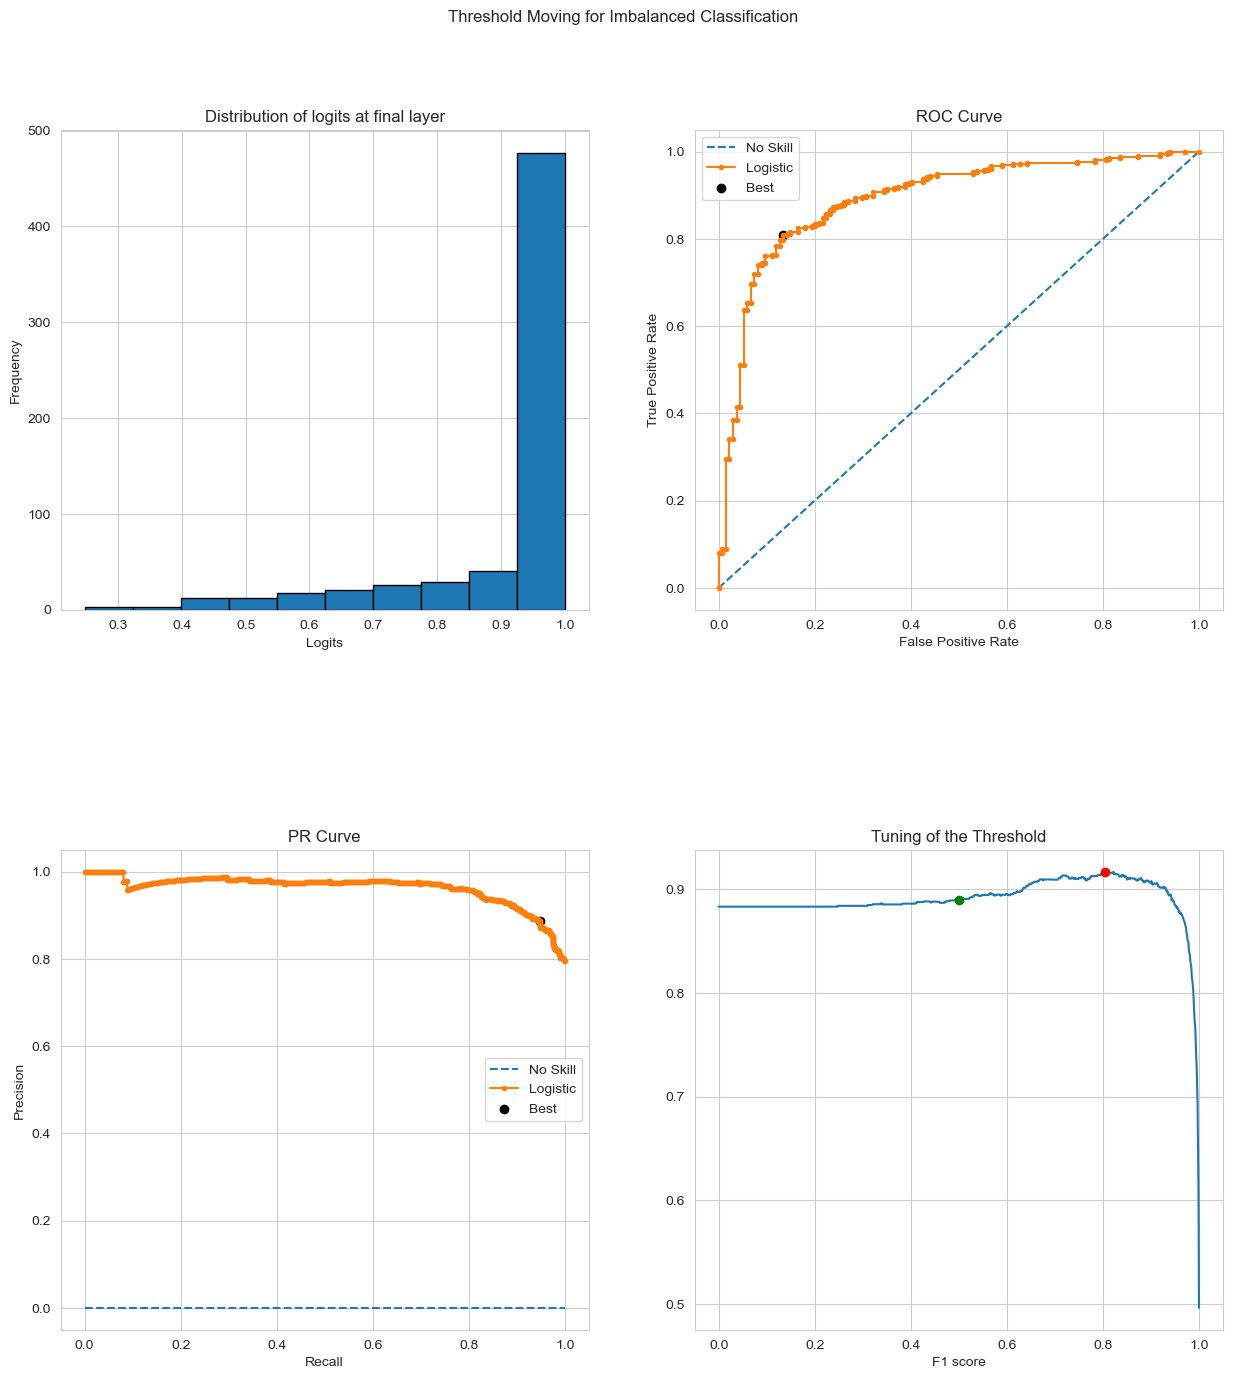

In [37]:
tuner.find_optimal_thresholds()

In [ ]:
nasnet.save("/kaggle/working/nasnetmobile")

20/20 [==============================] - 60s 3s/step
              precision    recall  f1-score   support

Not Infected       0.50      0.89      0.64       134
    Infected       0.96      0.76      0.85       506

    accuracy                           0.79       640
   macro avg       0.73      0.82      0.74       640
weighted avg       0.86      0.79      0.81       640



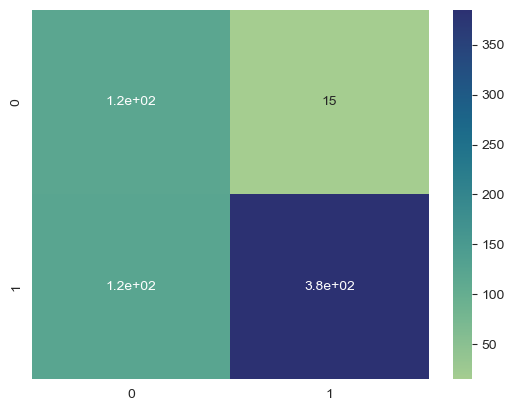

In [38]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], nasnet, nasnet_test, 0.976)
me.predict()
me.class_report()

**ResNet**

In [ ]:
resnet, history, resnet_test = experiment_model(cnns.resnet, 
                                        cnns.resnet.ResNet152(include_top=Falinput_shape=(200,200,3)),
                                        (200,200))

Found 1920 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Found 640 validated image filenames belonging to 2 classes.
Epoch 1/50
44/60 [=====================>........] - ETA: 11:30 - loss: 7.5331 - accuracy: 0.7188 - auc: 0.4476 - false_negatives: 117.0000 - false_positives: 279.0000 - precision: 0.7800 - recall: 0.8942

In [ ]:
me = ModelEvaluator(history, ["Not Infected", "Infected"], resnet, resnet_test, 0.5)

In [ ]:
me.training_history()
me.predict()

In [ ]:
me.class_report()

In [ ]:
tuner = ThresholdTuner(resnet, resnet_test)

In [ ]:
tuner.find_optimal_thresholds()

In [ ]:
resnet.save("/kaggle/working/resnet152_new")

**Ensemble**

In [ ]:
# A class for creatiing a Voting Ensemble.
class VotingEnsemble:

    # Initialization of the set of weak learners, set of their decision thresholds, 
    # and set of their preprocessing functions. 
     def __init__(self, weak_learners : list, thresholds : list, preprocessing_functions : list):
            self.wlearners = weak_learners
            self.thresholds = thresholds
            self.preprocessing_functions = preprocessing_functions
            self.INPUT_SIZE = (200, 200)
            self.predictions = []
            self.current_model_threshold = 0.5
            self.final_predictions = []
            self.ground_truth = []
            self.classes = ["Not Infected", "Infected"]
    
    # Application of the decision threshold to the model logits.
     def __clip_logits(self, p : float):
            if p >= self.current_model_threshold:
                return 1
            else:
                return 0
    
    # Obtaining the independet results for each of the weak learners
     def predict_independently(self):
            for i in range(0, len(self.wlearners)):
                # Loading serialized model.
                learner = tf.keras.models.load_model(self.wlearners[i])
                self.current_model_threshold = self.thresholds[i]

                # Re-computing its preprocessing test data.
                preprocessor = ImagePreprocessor(self.preprocessing_functions[i], 
                                                 self.INPUT_SIZE)
                preprocessor.create_generators()
                _ , _ , test = preprocessor.preprocess()

                # Storing ground truth and independent model predictions.
                self.ground_truth = list(test.labels)
                self.predictions.append(list(map(self.__clip_logits,learner.predict(test).flatten())))
     
     # Finding the majority classes based on the Vote bank for each training sample.
     def majority_vote(self):
           for i in range(0, len(self.predictions[0])):
                vote_bank = collections.Counter([self.predictions[j][i] for j in range(0, len(self.predictions))])
                if vote_bank[0] > vote_bank[1]:
                    self.final_predictions.append(0)
                else:
                    self.final_predictions.append(1)
    
    # Evaluation of the ensemble using confusion matrix and classification report.
     def evaluate_ensemble(self):
           sns.heatmap(tf.math.confusion_matrix(self.ground_truth, self.final_predictions, num_classes=2), 
                    annot=True, cmap="crest")
           print(classification_report(self.ground_truth, self.final_predictions, target_names=self.classes))

In [ ]:
# Set of the paths to the serialized models.
weak_learners = ["/kaggle/working/efficientnetb4",
                 "/kaggle/working/efficientnetb0",
                 "/kaggle/working/vgg16_"]

# Set of the decision thresholds from Grid Search techniques.
# Results are not much different with PR Curver either.
thresholds = [0.321, 0.575, 0.853]

# Set of the preprocessing functions of the weak learners.
preprocessing_functions = [ cnns.efficientnet,
                            cnns.efficientnet,
                            cnns.vgg16]

# Initialize the ensemble.
voter = VotingEnsemble(weak_learners, thresholds, preprocessing_functions)

In [ ]:
voter.predict_independently()

In [ ]:
voter.majority_vote()

In [ ]:
voter.evaluate_ensemble()

In [ ]:
models = ["vgg16_", "nasnetmobile", "resnet152_"]
pfs = [cnns.efficientnet, cnns.efficientnet, cnns.vgg16, cnns.nasnet, cnns.resnet]
img_sizes = [(200,200)]*3 + [(224,224)] + [(200,200)]
ground_truth = []
colors = ["red", "orange", "yellow", "purple", "green"]
plt.plot([0,1], [0,1], linestyle='--', label='No Skill', color="black")
for model, color, pf, size in zip(models, colors, pfs, img_sizes):
    learner = tf.keras.models.load_model(model)
    preprocessor = ImagePreprocessor(pf, size)
    preprocessor.create_generators()
    _, _, test = preprocessor.preprocess()
    ground_truth = list(test.labels)
    predictions = learner.predict(test).flatten()
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions)
    plt.plot(fpr, tpr, marker='.', label=model.replace("_",""), color=color)  
fpr, tpr, thresholds = roc_curve(voter.ground_truth, pred)
plt.plot(fpr, tpr, marker='.', label="Ensemble", color="blue")  
plt.title("Comparative ROC Curve for Binary Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
trn = dict()
tst = dict()

In [ ]:
for model, pf in zip(weak_learners, preprocessing_functions):
    learner = tf.keras.models.load_model(model)
    preprocessor = ImagePreprocessor(pf, (200, 200))
    preprocessor.create_generators()
    train, _, test = preprocessor.preprocess()
    t1 = list(train.labels)
    t2 = learner.predict(train).flatten()
    trn[model] = {"Ground Truth": t1, "Predictions":t2}
    t1 = list(test.labels)
    t2 = learner.predict(test).flatten()
    tst[model] = {"Ground Truth": t1, "Predictions":t2}

In [ ]:
for i in tst:
    #trn[i]["Ground Truth"] = trn[i]["Ground Truth"].tolist()
    tst[i]["Predictions"] = tst[i]["Predictions"].tolist()

In [ ]:
import json
with open("/kaggle/working/train_stacking.json", 'w') as fp:
    json.dump(trn, fp)

In [ ]:
with open("/kaggle/working/test_stacking.json", 'w') as fp:
    json.dump(tst, fp)

**Stacking**

In [ ]:
class StackingEnsemble:
    
    def __init__(self, weak_learners : list, thresholds : list, train : str, test : str, meta_classifier):
        self.weak_learners = weak_learners
        self.thresholds = thresholds
        self.train = json.load(open(train, "r"))
        self.test = json.load(open(test, "r"))
        self.features = ["f1", "f2"]
        self.target = "target"
        self.clf = meta_classifier
        
    def prepare_meta_dataset(self):
        d = dict()
        w1, w2, w3 = weak_learners
        t1, t2, t3 = thresholds
        #print(w1, w2, w3)
        d["f1"] = (np.array(self.train[w1]["Predictions"]) > t1).astype(np.int64)
        d["f2"] = (np.array(self.train[w2]["Predictions"]) > t2).astype(np.int64)
        d["f3"] = (np.array(self.train[w3]["Predictions"]) > t3).astype(np.int64)
        d["target"] = self.train[w1]["Ground Truth"]
        self.train_csv = pd.DataFrame.from_dict(d)
        d["f1"] = (np.array(self.test[w1]["Predictions"]) > t1).astype(np.int64)
        d["f2"] = (np.array(self.test[w2]["Predictions"]) > t2).astype(np.int64) 
        d["f3"] = (np.array(self.test[w3]["Predictions"]) > t3).astype(np.int64)
        d["target"] = self.test[w1]["Ground Truth"]
        self.test_csv = pd.DataFrame.from_dict(d)
    
    def train_model(self):
        self.clf.fit(self.train_csv[self.features], self.train_csv[self.target])
        
    def predict(self):
        self.predictions = self.clf.predict(self.test_csv[self.features])
    
    def class_report(self):
        sns.heatmap(tf.math.confusion_matrix(self.test_csv[self.target], self.predictions, num_classes=2), 
                    annot=True, cmap="crest")
        print(classification_report(self.test_csv[self.target], self.predictions, target_names=["Not Infected", "Infected"]))
        #print("AUC = ", roc_auc_score(self.test_csv[self.target], self.predictions))

In [ ]:
se = StackingEnsemble(weak_learners, thresholds, "/kaggle/working/train_stacking.json", 
                      "/kaggle/working/test_stacking.json",
                      DecisionTreeClassifier(max_depth=10, random_state=0, criterion="entropy"))

In [ ]:
se.prepare_meta_dataset()

In [ ]:
se.train_csv

In [ ]:
se.test_csv

In [ ]:
se.train_model()
se.predict()
se.class_report()

In [ ]:
se = StackingEnsemble(weak_learners, thresholds, "/kaggle/working/train_stacking.json", 
                      "/kaggle/working/test_stacking.json",
                      LogisticRegression(random_state=1))

In [ ]:
se.prepare_meta_dataset()

In [ ]:
se.train_model()
se.predict()
se.class_report()

# 